In [1]:
import numpy.random
from kendall import KendallSimulator, KendallServer, KendallEvent
from kendall.queues import RandomServerQueue
from kendall.spawners import ExponentialSpawner


def average(list):
    return sum(list) / float(len(list))


class Crane(KendallServer):
    def __init__(self, queue, id):
        self.queue = queue
        self.id = id
        self.reset()

    def assign(self, event, time):
        self.event = event
        self.start_time = time

    def complete(self, event, time):
        self.event = None
        self.total_time += time - self.start_time
        self.start_time = None

    def reset(self):
        self.event = None
        self.start_time = None
        self.total_time = 0.00


class ShipUnloadingEvent(KendallEvent):
    count = 0
    last_spawn_time = 0.0
    spawn_delays = []
    processing_times = []
    waiting_times = []

    def __init__(self, *args, **kwargs):
        super(ShipUnloadingEvent, self).__init__(*args, **kwargs)
        ShipUnloadingEvent.count += 1
        self.count = ShipUnloadingEvent.count
        self._processing_time = numpy.random.uniform(0.0, 1.5)

    def on_enqueue(self, queue, time):
        self.enter_time = time
        ShipUnloadingEvent.spawn_delays.append(time - ShipUnloadingEvent.last_spawn_time)
        ShipUnloadingEvent.processing_times.append(self._processing_time)
        ShipUnloadingEvent.last_spawn_time = time
        # print "Ship {} entered harbor at {}! Current queue: {}".format(self.count, time, len(queue.queue))

    def on_process(self, queue, time):
        # print "Ship {} berthed at {}!".format(self.count, time)
        pass

    def on_finish(self, queue, time):
        self.exit_time = time
        ShipUnloadingEvent.waiting_times.append(self.exit_time - self.enter_time)
        # print "Ship {} left harbor at {}!".format(self.count, time)

    def processing_time(self, server):
        return self._processing_time


class Harbor(RandomServerQueue):
    server_class = Crane


class ShipSpawner(ExponentialSpawner):
    pipe_event_class = ShipUnloadingEvent


class HomeworkSimulator(KendallSimulator):
    all_spawn_delays = []
    all_processing_times = []
    all_minimums = []
    all_averages = []
    all_maximums = []
    all_cranes = [[], []]
    all_delays = []

    def create_queues(self):
        self.ship_spawner = ShipSpawner(self, 1.25)
        self.harbors = Harbor(self, server_count=2)

        self.register_queue("Ship Spawner", self.ship_spawner)
        self.register_queue("Harbors", self.harbors)
        self.ship_spawner.pipe(self.harbors)

    def reset(self):
        super(HomeworkSimulator, self).reset()
        self.ship_spawner.start()
        ShipUnloadingEvent.count = 0
        ShipUnloadingEvent.last_spawn_time = 0.0
        ShipUnloadingEvent.spawn_delays = []
        ShipUnloadingEvent.processing_times = []
        ShipUnloadingEvent.waiting_times = []

    def analyze(self):
        minimum = min(ShipUnloadingEvent.waiting_times)
        average = sum(ShipUnloadingEvent.waiting_times) / len(ShipUnloadingEvent.waiting_times)
        maximum = max(ShipUnloadingEvent.waiting_times)
        # print "Minimum:", minimum
        # print "Average:", average
        # print "Maximum:", maximum
        for num, crane in enumerate(self.harbors.servers):
            if crane.start_time is not None:
                crane.complete(crane.event, 100.0)
            util = crane.total_time / 100.00
            # print "Utilization of Crane {}:", util
            HomeworkSimulator.all_cranes[num].append(util)
        delay = len([x for x in ShipUnloadingEvent.waiting_times if x >= 2.00]) / float(len(ShipUnloadingEvent.waiting_times))
        # print "Percent over 2 days:", delay
        HomeworkSimulator.all_spawn_delays.extend(ShipUnloadingEvent.spawn_delays)
        HomeworkSimulator.all_processing_times.extend(ShipUnloadingEvent.processing_times)
        HomeworkSimulator.all_minimums.append(minimum)
        HomeworkSimulator.all_maximums.append(maximum)
        HomeworkSimulator.all_averages.append(average)
        HomeworkSimulator.all_delays.append(delay)

sim = HomeworkSimulator(100)
for x in xrange(1, 1000):
    processing_times = []
    sim.reset()
    sim.run()
    sim.analyze()


In [2]:
import matplotlib.pyplot as plt

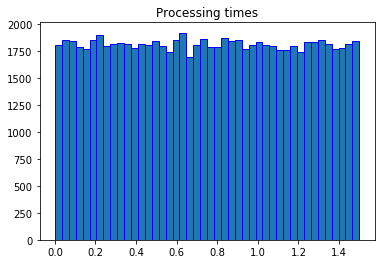

Average processing time: 0.748535939558


In [3]:
plt.hist(HomeworkSimulator.all_processing_times, bins='auto', edgecolor="blue")
plt.title("Processing times")
plt.show()

print "Average processing time:", average(HomeworkSimulator.all_processing_times)

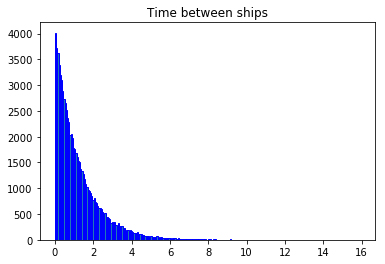

Average time between ships: 1.23622770569


In [4]:
plt.hist(HomeworkSimulator.all_spawn_delays, bins='auto', edgecolor="blue")
plt.title("Time between ships")
plt.show()

print "Average time between ships:", average(HomeworkSimulator.all_spawn_delays)

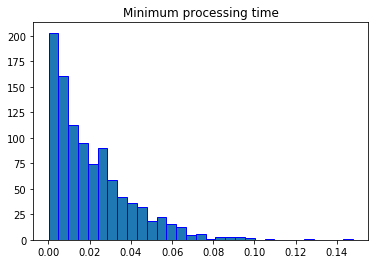

Average Minimum: 0.0207323189014


In [5]:
plt.hist(HomeworkSimulator.all_minimums, bins='auto', edgecolor="blue")
plt.title("Minimum processing time")
plt.show()

print "Average Minimum:", average(HomeworkSimulator.all_minimums)

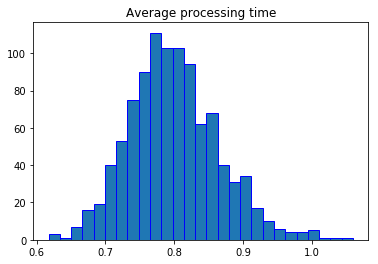

Mean Average: 0.799391587009


In [6]:
plt.hist(HomeworkSimulator.all_averages, bins='auto', edgecolor="blue")
plt.title("Average processing time")
plt.show()

print "Mean Average:", average(HomeworkSimulator.all_averages)

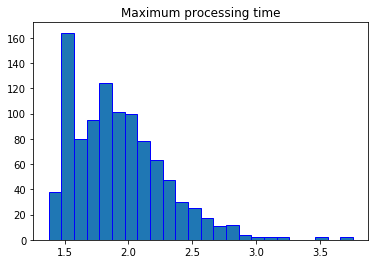

Mean Maximum: 1.92154257069


In [7]:
plt.hist(HomeworkSimulator.all_maximums, bins='auto', edgecolor="blue")
plt.title("Maximum processing time")
plt.show()

print "Mean Maximum:", average(HomeworkSimulator.all_maximums)

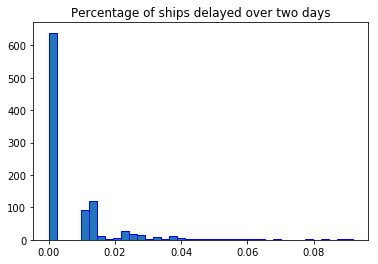

Mean Percentage Delayed: 0.00766633894508


In [8]:
plt.hist(HomeworkSimulator.all_delays, bins='auto', edgecolor="blue")
plt.title("Percentage of ships delayed over two days")
plt.show()

print "Mean Percentage Delayed:", average(HomeworkSimulator.all_delays)

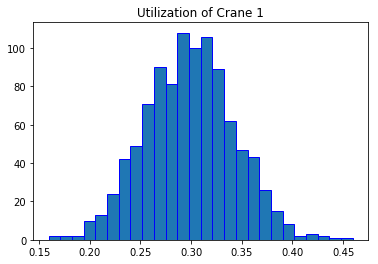

Mean Utilization of Crane 1: 0.298517358766


In [9]:
plt.hist(HomeworkSimulator.all_cranes[0], bins='auto', edgecolor="blue")
plt.title("Utilization of Crane 1")
plt.show()

print "Mean Utilization of Crane 1:", average(HomeworkSimulator.all_cranes[0])


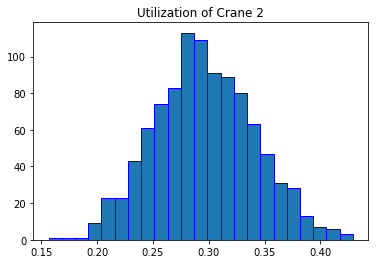

Mean Utilization of Crane 2: 0.296189836342


In [10]:
plt.hist(HomeworkSimulator.all_cranes[1], bins='auto', edgecolor="blue")
plt.title("Utilization of Crane 2")
plt.show()

print "Mean Utilization of Crane 2:", average(HomeworkSimulator.all_cranes[1])